In [1]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install textblob

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
df=pd.read_csv("amazon_reviews.csv")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [5]:
#converting text to lowercase
df['reviewText'] = df['reviewText'].str.lower()

# Punctuations
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

# Numbers
df['reviewText'] = df['reviewText'].str.replace('\d', '')

In [6]:
# STOPWORDS
import nltk
nltk.download('stopwords')
sw = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

[nltk_data] Downloading package stopwords to /home/kyalo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Rarewords

drops = pd.Series(' '.join(df['reviewText']).split()).value_counts()[-1000:]
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [8]:
# TOKENIZATION

# nltk.download("punkt")
df["reviewText"].apply(lambda x: TextBlob(x).words).head()

0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, sprung, higher, capacity, th...
3    [think, worked, great.had, diff, bran, 64gb, c...
4    [bought, retail, packaging, arrived, legit, or...
Name: reviewText, dtype: object

In [10]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/kyalo/nltk_data...


True

In [11]:
# LEMMATIZATION

# nltk.download('wordnet')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df['reviewText'].head(10)

0                                              issues.
1    purchased device, worked advertised. never muc...
2    work expected. sprung higher capacity. think m...
3    think worked great.had diff. bran 64gb card we...
4    bought retail packaging, arrived legit, orange...
5    mini storage. anything else supposed to. purch...
6    phone never skip beat. file transfer speedy co...
7    hard believe affordable digital become. 32 gb ...
8    work htc rezound. running short space 64gb san...
9    galaxy s4, super fast card, totally happy, hap...
Name: reviewText, dtype: object

In [12]:
#STEMMING
# create an instance of PorterStemmer
porter = PorterStemmer()

# define a function to apply stemming to each word in a sentence
def stem_words(text):
    return " ".join([porter.stem(word) for word in text.split()])

# apply stemming to the 'reviewText' column in your DataFrame
df['reviewText'] = df['reviewText'].apply(stem_words)

# display the first 10 rows of the 'reviewText' column
df['reviewText'].head(10)

0                                              issues.
1    purchas device, work advertised. never much ph...
2    work expected. sprung higher capacity. think m...
3    think work great.had diff. bran 64gb card went...
4    bought retail packaging, arriv legit, orang en...
5    mini storage. anyth els suppos to. purchas add...
6    phone never skip beat. file transfer speedi co...
7    hard believ afford digit become. 32 gb devic o...
8    work htc rezound. run short space 64gb sandisk...
9    galaxi s4, super fast card, total happy, happi...
Name: reviewText, dtype: object

In [13]:
#term frequency

tf = df["reviewText"].apply(lambda x: pd.Series(x).value_counts()).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.head()

,words,tf
0,issues.,2.00
1,"purchas device, work advertised. never much ph...",1.00
2,work expected. sprung higher capacity. think m...,1.00
3,think work great.had diff. bran 64gb card went...,1.00
4,"bought retail packaging, arriv legit, orang en...",1.00


In [14]:
tf.shape

(4913, 2)

In [15]:
tf["tf"].describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99]).T

count   4913.00
mean       1.00
std        0.02
min        1.00
5%         1.00
10%        1.00
25%        1.00
50%        1.00
75%        1.00
80%        1.00
90%        1.00
95%        1.00
99%        1.00
max        2.00
Name: tf, dtype: float64

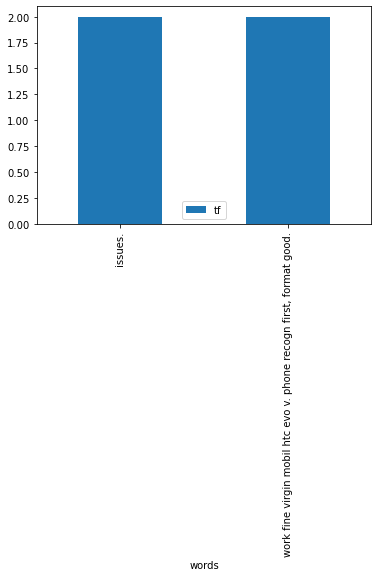

In [16]:
# Barplot

tf[tf["tf"] > 1].plot.bar(x="words", y="tf")
plt.show()

In [35]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","purchas device, work advertised. never much ph...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected. sprung higher capacity. think m...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think work great.had diff. bran 64gb card went...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","bought retail packaging, arriv legit, orang en...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [36]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kyalo/nltk_data...


In [37]:
sia.polarity_scores("The film was awesome")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [38]:
sia.polarity_scores("I liked this music but it is not good as the other one")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [39]:
df["reviewText"].apply(lambda x: x.upper())

0                                                 ISSUES.
1       PURCHAS DEVICE, WORK ADVERTISED. NEVER MUCH PH...
2       WORK EXPECTED. SPRUNG HIGHER CAPACITY. THINK M...
3       THINK WORK GREAT.HAD DIFF. BRAN 64GB CARD WENT...
4       BOUGHT RETAIL PACKAGING, ARRIV LEGIT, ORANG EN...
                              ...                        
4910    BOUGHT SANDISK 16GB CLASS 10 USE HTC INSPIRE, ...
4911    USE EXTEND CAPABL SAMSUNG GALAXI NOTE 10. GREA...
4912    GREAT CARD FAST RELIABLE. COME OPTION ADAPT SD...
4913     GOOD AMOUNT SPACE STUFF WANT DO, FIT GOPRO. SAY?
4914    I'V HEARD BAD THING 64GB MICRO SD CARD CRAP WE...
Name: reviewText, Length: 4915, dtype: object

In [40]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2    {'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...
3    {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'comp...
4    {'neg': 0.0, 'neu': 0.771, 'pos': 0.229, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.108, 'neu': 0.674, 'pos': 0.218, 'co...
7    {'neg': 0.035, 'neu': 0.748, 'pos': 0.217, 'co...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'comp...
Name: reviewText, dtype: object

In [41]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.00
1   0.00
2   0.40
3   0.40
4   0.86
5   0.00
6   0.75
7   0.81
8   0.00
9   0.82
Name: reviewText, dtype: float64

In [42]:
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","purchas device, work advertised. never much ph...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected. sprung higher capacity. think m...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think work great.had diff. bran 64gb card went...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.40
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","bought retail packaging, arriv legit, orang en...",5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86


In [43]:
#Feature Prediction
df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    neg
1    neg
2    pos
3    pos
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: reviewText, dtype: object

In [44]:
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00,neg
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","purchas device, work advertised. never much ph...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00,neg
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected. sprung higher capacity. think m...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40,pos
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think work great.had diff. bran 64gb card went...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.40,pos
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","bought retail packaging, arriv legit, orang en...",5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86,pos
5,A2IDCSC6NVONIZ,B007WTAJTO,2Cents!,"[0, 0]",mini storage. anyth els suppos to. purchas add...,5.00,Not a lot to really be said,1367193600,2013-04-29,588,0,0,0.00,neg
6,A26YHXZD5UFPVQ,B007WTAJTO,2K1Toaster,"[0, 0]",phone never skip beat. file transfer speedi co...,5.00,Works well,1382140800,2013-10-19,415,0,0,0.75,pos
7,A3CW0ZLUO5X2B1,B007WTAJTO,"35-year Technology Consumer ""8-tracks to 802.11""","[0, 0]",hard believ afford digit become. 32 gb devic o...,5.00,32 GB for less than two sawbucks...what's not ...,1404950400,2014-10-07,62,0,0,0.81,pos
8,A2CYJO155QP33S,B007WTAJTO,4evryoung,"[1, 1]",work htc rezound. run short space 64gb sandisk...,5.00,Loads of room,1395619200,2014-03-24,259,1,1,0.00,neg
9,A2S7XG3ZC4VGOQ,B007WTAJTO,53rdcard,"[0, 0]","galaxi s4, super fast card, total happy, happi...",5.00,works great,1381449600,2013-11-10,393,0,0,0.82,pos


In [45]:
#ideating positive and negative sentiments in total
df["sentiment_label"].value_counts()

sentiment_label
pos    3752
neg    1163
Name: count, dtype: int64

In [46]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

X = df["reviewText"]
y = df["sentiment_label"]

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word')
X_w = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()
X_w.toarray()

NameError: name 'corpus' is not defined

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

In [50]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

vectorizer.get_feature_names()[10:15]
X_count.toarray()[10:15]

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [51]:
#MODEL
log_model = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model,
                X_tf_idf_word,
                y, scoring="accuracy",
                cv=5).mean()

yeni_yorum = pd.Series("this product is great")
yeni_yorum = pd.Series("look at that shit very bad")
yeni_yorum = pd.Series("it was good but I am sure that it fits me")

yeni_yorum = CountVectorizer().fit(X).transform(yeni_yorum)
log_model.predict(yeni_yorum)

NameError: name 'X_tf_idf_word' is not defined

In [52]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

vectorizer.get_feature_names()[10:15]
X_count.toarray()[10:15]

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [53]:
random_review = pd.Series(df["reviewText"].sample(1).values)
random_review

0    alway pleas sandisk product one exception. wor...
dtype: object

In [54]:
#Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

0.8280773143438453

In [ ]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [5, 8, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 20],
             "n_estimators": [100, 200, 500]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_count, y)

rf_best_grid.best_params_
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)
cv_results = cross_validate(rf_final, X_count, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
cv_results = cross_validate(rf_final, X_count, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])